# 타이타닉 생존자 가려내기

### step 1 탐색: 타이타닉 데이터 살펴보기
타이타닉 데이터셋의 구성은 다음과 같습니다.

+ pclass:Passenger Class, 승객 등급
+ survived: 생존 여부(생존은 1, 아닌 경우는 0)
+ name: 승객 이름
+ sex: 승객 성별
+ age: 승객 나이
+ sibsp: 동승한 형제 또는 배우자 수
+ parch: 동승한 부모 또는 자녀 수
+ ticket: 티켓 번호
+ fare: 승객 지불 요금
+ cabin: 선실 이름
+ embarked: 승선항(C=쉘 부르크, Q=퀸즈타운, S=사우스 햄튼)
+ body: 사망자 확인 번호
+ home.dest: 고향/목적지

분석에 사용할 데이터는 총 2개의 파일로 구성되어 있습니다.  
하나는 분류 모델의 학습을 위한 학습 데이터셋, 그리고 나머지 하나는 테스트를 위한 테스트 데이터셋입니다.  
그리고 각 데이터의 age,cabin,body,home,dest 피처에는 결측치가 존재합니다.  
다음의 코드로 이를 확인해 봅시다.

In [12]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [13]:
df_train = pd.read_csv("./data/titanic_train.csv")
df_test = pd.read_csv("./data/titanic_test.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [14]:
print(df_train.info())
print("-----------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-

먼저 name,ticket,body, home.dest, cabin 피처를 제거합니다.  
이 피처들은 지금 당장 분석에 활용할 수 없거나 (name, cabin), 큰 의미를 가지고 있지 않은 피처(ticket, home.dest, body) 이기 때문입니다.

- 불필효한 피처 제거하기

In [15]:
# 데이터셋에서 name, ticket, body, cabin, home.dest 피처를 제거합니다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

다음으로 각 피처가 분류 분석에 미칠 영향에 대해 탐색해봅시다.  
이를 탐색하는 가장 좋은 방법은 데이터를 그룹(생존자 그룹 / 비생존자 그룹)으로 나누어 피처의 그룹 간 차이를 탐색하는 것입니다.  
생존 여부 (생존 = 1, 아닌 경우 = 0)인 survived를 그룹으로 하여 pclass 피처의 그룹별 분포를 출력한 결과는 아래와 같습니다.  
seaborn의 countplot이라는 함수를 사용하면 아래와 같은 그래프를 출력할 수 있습니다. 그룹 비율은 약 3:5 정도로 나타났고,  
그룹별 pclass의 분포는 상이하게 나타났습니다.  
이를 통해 pclass 피처는 생존자 분류에 유의미한 영향을 미친다는 가설을 세워 볼 수 있습니다.

+ 탐색적 데이터 분석하기

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

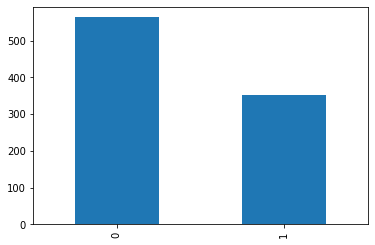

In [16]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


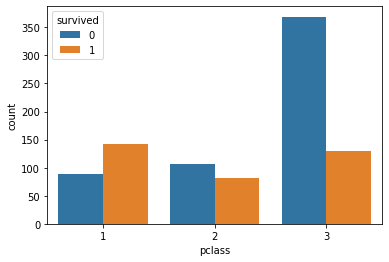

In [17]:
# survived 피처를 기준으로 그룹을 나누어, 그룹별 pclass 피처의 분포를 살펴봅니다.
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)

다음으로 age, sibsp와 같은 수치형 피처들에 대한 탐색을 진행합니다.  
다음의 코드는 이러한 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 작성한 것입니다.  
함수가 실행하는 내용은 다음과 같습니다.  
  
    
+ 두 그룹 간의 분포를 비교하는 그래프를 출력합니다.
+ 두 그룹 각각의 표준편차를 출력합니다.
+ 두 그룹 간의 T-test 검정을 실시하여 출력합니다.
+ 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력합니다.

##### shapiro - wilk 검정
Shapiro-wilk 검정이란 주어진 데이터가 얼마나 정규성을 따르는지. 즉 얼마나 정규분포에 가까운지를 측정하는 검정입니다.

+ 변수 탐색작업 자동화하기

In [18]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    
    # 두 집단 (survived=1, survived=0)의 분포 그래프를 출력합니다.
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # 두 집단 (survived=1, survived=0)의 표준편차를 각각 출력합니다.
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    
     # T-test로 두 집단의 평균 차이를 검정합니다.
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 정도를 검증합니다.
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

아래의 실행 결과는 valid_features()를 실행한 것입니다. 이를 통해 살펴본 피처는 age, sibsp 두 피처입니다.

+ 자동화 함수 실행하기

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


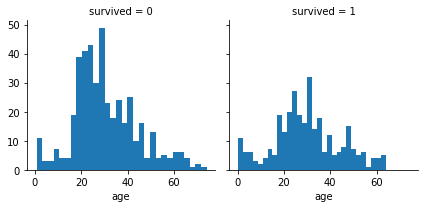

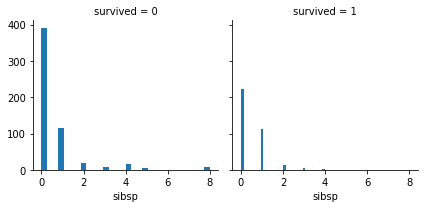

In [19]:
# 앞서 정의한 valid_features 함수를 실행합니다. age 피처와 sibsp 피처를 탐색합니다.
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)
valid_features(df_train, 'sibsp', distribution_check=False)

분석 결과, age 피처는 두 그룹 간의 평균 차이가 없기 때문에 생존자 분류에 미치는 영향력이 낮을것이라고 가정해볼 수 있습니다.  
반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느 정도 존재 한다는것을 알 수 있습니다.

다음의 표는 지금까지 탐색한 피처의 내용을 정리한 것입니다.

탐색 대상 피처 | 두 그룹 간의 분포 혹은 평균의 차이가 있는가?
--- | ---
pclass | O
age | x
sibsp,parch | △
fare | O
sex | O
embarked | △

# step 2 분류: 생존자 분류 모델 만들기

이제 분류 모데을 만들어 보겠습니다.  
예측 모델과 마찬가지로 분류 모델 역시 다양한 방법이 존재합니다. 첫 번째로 시도해볼 방법은 로지스틱 회귀 모델을 이용한 분류입니다.  
로지스틱 회기 모델은 기존 회귀 분석의 예측값 Y를 0~1 사이의 값으로 제한하여 0.5보다 크면 1, 0.5보다 작은면 0이라고 분류하는 방법입니다  
로지스틱 회귀 모델은 일반적인 회귀 모델과 마찬가지로 계수 분석을 통한 피처의 영향력 해석이 용이하다는 장점이 있습니다.  
로지스틱 모델을 사용하기 위해 회귀 분석을 수행할 때와 동일한 방법으로 데이터를 가공합니다.  
우선 결측값을 처리합니다. 결측값이 존재하는 피처를 전처리하는 방법은 크게 두 가지입니다.

+ 1.결측이 존재하는 데이터들을 삭제하는 방법
+ 2.평균값, 혹은 중앙값이나 최빈값 등의 임의의 수치로 채워 넣는 방법  
  
1은 처리가 쉽고 분석에서의 주관이 개입될 여지가 없다는 장점이 있습니다. 하지만 중요한 정보를 삭제하게 될 수도 있겠지요.  
2는 데이터를 모두 분석에 활용할 수 있다는 장점이 있지만, 수치 왜곡의 가능성이 있다는 단점이 있습니다.  

아래의 코드에서는 2를 이용하여 age와 embark 피처의 결측값을 보정하였습니다.  
그리고 원 - 핫인코딩 방법으로 범주형 변수를 변환합니다. 현재 데이터셋은 train 데이터와 test 데이터로 분리되어 있기 때문에 원 - 핫 인코딩을 적용하려면 하나의 데이터로 합쳐줄 필요가 있습니다. 그래서 두 데이터를 합친 whole_df에 원-핫 인코딩을 적용한 뒤, 다시 train과 test로 데이터를 분리합니다.

### 분류 모델을 위해 전처리하기

In [20]:
# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark: 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df)을 생성합니다.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# pandas 패키지를 이용한 원-핫 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


이제 sklearn 모듈의 LogisticRegression 클래스로 모델을 학습합니다.  
학습 코드는 아래와 같습니다.

### 분류 모델링: 로지스틱 회귀 모델

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_train.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

그렇다면 이 모델이 생존자를 얼마나 잘 분류하는지 어떻게 평가할까요?  
일반적으로 분류 모델의 평가 기준은 Confusion Matrix라는 것을 활용합니다.  
Predicted class는 모델이 예측하여 분류한 값, 그리고 Actual Class는 실제 데이터의 값입니다.  

1. True Positives: 1인 값을 1이라 하는 경우를 True Positives라고 합니다. 이는 관심 범주를 정확하게 분류한 것을 의미합니다.
1. False Negatives: 1인 값을 0이라 하는 경우를 False Negatives라고 합니다. 이는 관심 범주가 아닌 것으로 잘못 분류한 경우입니다.
1. False Positives: 0인 값을 1이라 하는 경우를 False Positives라고 합니다. 이는 관심 범주라고 분류한 것이 잘못된 경우입니다.
1. True Negatives: 0인 값을 0이라 하는 경우를 True Negatives라고 합니다. 이는 관심 범주가 아닌 것을 아니라고 정확하게 분류한 경우입니다.

이 정보들을 이용한 분류의 평가 지표들은 다음과 같습니다.

+ 정확도(Accuracy)
+ 정밀도(Precision)
+ 재현도(Recall)
+ 특이도(Specificity)

이 지표들을 응용한 두 가지 평가 지표가 F1-score와 ROC Curve입니다. F1-score는 정밀도와 재현도의 조화 평균값으로,  
두 값을 동시에 고려할 때 사용하는 지표입니다. 그리고 ROC Curve는 아래의 그림처럼 재현도(민감도)와 특이도를 고려하여 종합적인 모델의 성능을 그래프로 나타내는 것인데, 그래프의 넓이를 계산한 AUC를 성능의 지표로 사용합니다. 이 값이 1에 가까울수록 좋은 분류 모델입니다.
다음 코드는 정확도, 정밀도, 특이도 F1-score 네 가지 지표로 모델을 평가한 것입니다.
predict() 함수로 분류한 예측값들을 sklearn.metrics 모듈의 accuracy_score, precision_score, recall_score, f1_score  
함수에 적용하면 다음과 같은 출력 결과를 얻을 수 있습니다.

#### 분류 모델 평가하기

In [22]:
# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


그리고 다음의 코드는 Confusion Matrix를 직접 출력한 것입니다.

In [23]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


마지막으로 AUC를 출력해봅시다. AUC 출력은 분류 결과인 0 혹은 1의 y값(y_pred)을 사용하는 것이 아니라, 분류 직전의 확률값(y_pred_probability)인 0~1 사이의 값을 사용해야 합니다. 아래 코드는 AUC를 출력함과 동시에 ROC Curve를 그래프로 나타낸 것입니다.  
이 모델의 AUC는 약 0.837로, 생존자를 잘 분류해내는 모델이라고 평가할 수 있습니다.

#### 로지스틱 회귀 모델의 AUC 구하기

AUC : 0.838


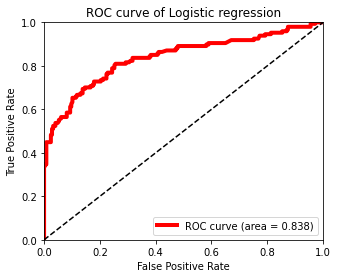

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

아래의 코드와 실행 결과는 로지스틱 회귀 모델과 더불어 분류 분석의 가장 대표적인 방법인 의사결정 나무 모델을 적용한 결과 입니다.  
하지만 로지스틱 회귀 모델에 비해 모든 평가 지표가 낮은 것을 확인할 수 있습니다.

#### 의사결정 나무 모델

의사결정 나무 모델은 피처 단위로 조건을 분기하여 정답의 잡합을 좁혀나가는 방법입니다.  
마치 스무고개 놀이에서 정답을 찾아 나가는 과정과 유사하며, 이를 도식화하면 생김새가 '나무 모양'과 같다 하여 붙여진 이름 입니다.

타이타닉 탑승객의 생존 여부를 나타내는 결정 트리. sibsp는 탑승한 배우자와 자녀의 수를 의미한다.  
잎 아래의 숫자는 각각 생존 확률과 탑승객이 그앞에 해당될 확률을 의미한다.

#### 의사결정 나무

accuracy: 0.77
Precision : 0.703
Recall : 0.660
F1 : 0.681
AUC : 0.755


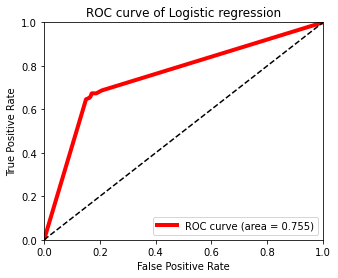

In [26]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환합니다.
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

# 학습한 모델의 AUC를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

# step 3 모델 개선: 피처 엔지니어링 첫걸음

분류 모델의 성능을 더욱 끌어올리기 위해서는 어떻게 해야 할까요?  
가장 먼저 생각해볼수 있는 것은 '더 좋은 분류 기법'을 사용하는 것입니다. 혹은 '더 많은 데이터'를 사용하는 것도 좋은 방법일 것입니다.  
하지만 이 방법들은 쉽게 적용할 수 있는 것들이 아닙니다.  
이럴 때 분석가가 사용할 수 있는 무기는 바로 피처 엔지니어링 입니다. 피처 엔지니어링이란 모델에 사용할 피처를 가공하는 분석 작업을 의미합니다.  
이를 수행하기 위해 분석 과정을 처음부터 다시 시작하겠습니다.  
먼저 다음의 코드와 같이 age, embark 피처의 결측값을 처리해준뒤, whole_df라는 통합 데이터 프레임을 생성합니다.

#### 분류 모델을 위해 전처리하기

In [28]:
# 데이터를 다시 불러옵니다.
df_train = pd.read_csv("./data/titanic_train.csv")
df_test = pd.read_csv("./data/titanic_test.csv")
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# one-hot encoding을 위한 통합 데이터 프레임(whole_df)을 생성합니다.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

이번에는 cabin 피처와 name 피처를 가공하여 분석에 포함합니다.  
cabin 피처는 선실의 정보를 나타내는 데이터로, 선실을 대표하는 알파벳이 반드시 첫 글자에 등장한다는 패턴을 가지고 있습니다.

#### cabin 피처 활용하기

In [29]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
D                  4
F33                4
C78                4
C22 C26            4
B96 B98            4
F2                 4
Name: cabin, dtype: int64


이 피처의 결측 데이터는 알파벳이 없다는 의미의 'X' 알파벳으로 채워줍니다.  
그리고 데이터의 수가 매우 적은 G와 T 선실 역시 'X'로 대체합니다.  
마지막으로 cabin 피처에서 첫 번째 알파벳을 추출하기 위해 whole_df['cabin'].apply(lambda x:x[0]) 코드를 실행합니다.

#### cabin 피처 활용하기

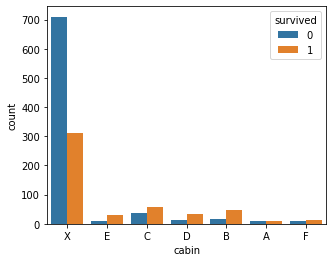

In [30]:
# 결측 데이터의 경우는 ‘X’로 대체합니다.
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 문자를 추출합니다.
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

# 추출한 문자 중, G와 T는 수가 너무 작기 때문에, 마찬가지로 ‘X’로 대체합니다.
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})

ax = sns.countplot(x='cabin', hue = 'survived',  data = whole_df)
plt.show()

전처리가 완료된 cabin 피처의 생존자/비생존자 그룹 간 분포는 위와 같습니다.  
이를 살펴본 결과, 두 그룹 간의 유의미한 차이가 있는 것으로 보입니다.  
따라서 우리는 이 피처를 분류 모델에 사용해볼 수 있습니다.  
다음으로 name 피처를 살펴봅시다. 얼핏 봐서는 이름이라는 데이터를 어떻게 피처로 사용할 수 있을지 난감합니다.  
하지만 데이터를 자세히 살펴보면 이 피처 또한 데이터 간의 공통점이 있음을 발견할 수 있습니다.  
바로 이름의 구성 중간에 들어가는 호칭 정보입니다.  
데이터셋 이름 중 Bradley, Miss. Bridget Delia 라는 이름을 예로 들어보겠습니다.  
이 이름은 Bradley라는 성, Miss라는 호칭, Bridget Delia라는 이름으로 구성되어 있습니다.  
그리고 모든 이름은 이러한 형태로 구성되어 있습니다.  
당시 시대는 사회적 계급이 엄연히 존재하였기 때문에 호칭 정보는 매우 중요한 데이터로 활용될 수 있습니다.  
호칭을 추출한 결과는 다음과 같습니다.

#### name 피처 활용하기

In [32]:
# 이름에서 호칭을 추출합니다.
name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


앞선 단계에서 추출한 호칭을 여섯 가지의 사회적 지위로 정의할 수 있습니다.  
아래 코드의 give_grade() 함수로 whole_df의 name 피처를 A~F의 범주형 데이터로 변환하는 작업을 수행합니다.

#### name 피처 활용하기

In [33]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의합니다.
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

# 정의한 호칭의 기준에 따라, A~F의 문자로 name 피처를 다시 정의하는 함수입니다.
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
# 위의 함수를 적용하여 name 피처를 새롭게 정의합니다.
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


변환된 피처의 각 범주별 개수를 출력한 결과는 위와 같습니다.

이제 모델을 학습하기 위한 마지막 전처리 단계로 모든 범주형 피처들에 원-핫 인코딩을 적용합니다.

#### 원-핫 인코딩

In [34]:
# pandas 패키지를 이용한 one-hot 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


전처리가 완료된 데이터 프레임의 출력 결과는 다음과 같습니다.  
cabin, name을 대상으로 피처 엔지니어링을 적용한 뒤, 다시 학습한 모델의 평가 결과는 아래와 같습니다.  
accuracy와 precision은 기존 모델에 비해 소폭 감소한 반면, F1 score와 AUC는 대폭 상승하였습니다.  
이를 통해 분류 모델의 성능이 많이 향상되었다는 것을 알 수 있습니다.

#### 피처 엔지니어링이 완료된 데이터셋 학습

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


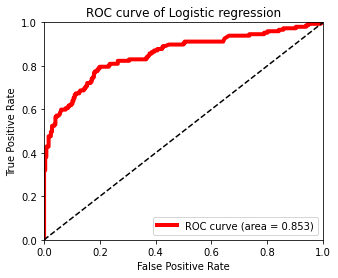

In [35]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

다음의 코드는 분류 모델의 피처 영향력을 그래프로 살펴본 것입니다.  
우리는 이를 통해 피처 엔지니어링으로 생성된 name, cabin 피처의 영향력이 가장 크다는 것을 알 수 있습니다.

#### 피처 영향력 살펴보기

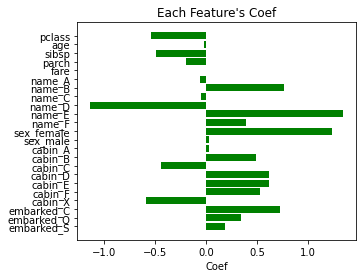

In [36]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환합니다. (그래프의 y축)
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 x축으로 하여, 피처 영향력 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

# step 4 평가: 모델 검증하기

마지막 단계는 완성된 분류 모델을 검증하는 단계입니다. 이를 위해 모델의 과적합 여부를 검증해야 합니다.  
우리가 알아볼 과적합 검증 방법은 두 가지입니다. 첫 번째는 K-fold 교차 검증, 그리고 두 번째는 학습 곡선을 살펴보는 방법입니다.

#### K-fold 교차 검증

학습용 데이터셋과 테스트용 데이터셋을 나눌 때, 두 데이터는 불균등하게 나눠졌을 가능성이 있습니다.  
K-fold 교차 검증은 이 가능성을 낮춰주는 방법으로, 데이터를 K개의 fold로 나누어 k-1개는 학습 데이터, 나머지 1개는 테스트 데이터로 사용하는 방법입니다.  
총 5회의 학습을 통해 모델의 분할 검증을 5회 반복하는 것입니다. 만약 이 k번의 검증 과정에서 테스트 점수 간의 차이가 크지 않다면 모델은 과적합이 일어났을 가능성이 낮은 것입니다.

k-fold 교차 검증을 수행하기 위한 코드는 아래와 같습니다.  
우선 sklearn.model_selection의 KFold 클래스로 cv라는 객체를 반환합니다.  
그리고 이 객체의 split 함수를 for 반복문과 같이 사용하는데, 반복문에서는 전체 데이터를 K개로 분리하여 학습과 평가를 반복합니다.

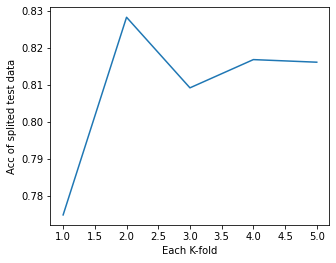

In [42]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정합니다.
k = 5
cv = KFold(k, shuffle=True, random_state=0)
auc_history = []

# K-fold를 5번의 분할 학습으로 반복합니다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):

    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정합니다. 매 반복시마다, 테스트 데이터셋은 변경됩니다.
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정합니다.
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    # 주어진 데이터로 로지스틱 회귀 모델을 학습합니다.
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    
    # 테스트 데이터셋의 Accuracy를 계산하여 auc_history에 저장합니다.
    splited_auc = accuracy_score(splited_y_test, y_pred)
    auc_history.append(splited_auc)
    
# auc_history에 저장된 5번의 학습 결과(Accuracy)를 그래프로 출력합니다.
plt.xlabel("Each K-fold")
plt.ylabel("Acc of splited test data")
plt.plot(range(1, k+1), auc_history) # baseline

위의 실행 결과는 교차 검증의 K번째 실행마다 AUC를 리스트에 저장하고, 이를 그래프로 나타낸 것입니다.  
그래프를 살펴본 결과, AUC가 큰 폭으로 변화하고 있는 것을 볼 수 있습니다.  
따라서 이모델은 다소 불안정한 모델이라고 할 수 있습니다.  
다만 이러한 결과는 데이터의 개수가 적기 때문에 발생하는 현상입니다.  
게다가 모든 실행에서 공통적으로 Test AUC가 0.8 이상의 수치를 기록했기 때문에 이 분류 모델은 '과적합이 발생했지만 대체로 높은 정확도를 가지는 모델'이라고 할 수 있습니다.

아래의 코드를 실행하기 앞ㅇ서 먼저 scikitplot 모듈을 설치해봅시다.

pip install scikit-plot

In [43]:
!pip install scikit-plot

  Using cached https://files.pythonhosted.org/packages/9d/40/5ba7d4a3f80d39d409f21899972596bf62c8606f1406a825029649eaa439/matplotlib-2.2.5-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 5.5MB 62kB/s ta 0:00:010
  Using cached https://files.pythonhosted.org/packages/24/40/11b12af7f322c1e20446c037c47344d89bab4922b8859419d82cf56d796d/scipy-1.2.3-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 296kB 133kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3d/78/cb9248b2289ec31e301137cedbe4ca503a74ca87f88cdbfd2f8be52323bf/kiwisolver-1.1.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https:/

In [47]:
!pip3 install scikit-plot

  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/55/85/70c6602b078bd9e6f3da4f467047e906525c355a4dacd4f71b97a35d9897/joblib-1.0.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/09/03/b7b30fa81cb687d1178e085d0f01111ceaea3bf81f9330c937fb6f6c8ca0/matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/11/e5862273960aef46cf98e571db5433bdabe5e816ef3317260dcdabc9b438/scikit_learn-0.24.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 3.0MB 142kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546f

학습 데이터와 테스트  데이터의 점수가 벌어지는 과적합 상황은 학습 곡선을 관찰함으로써 더 쉽게 관찰할 수 있습니다.  
다음의 그래프는 학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지를 관찰한 그래프입니다.  
이를 통해 데이터가 300개 이상인 경우에는 과적합의 위험이 낮아진다는 것을 알 수 있습니다.

#### 학습 곡선 분석하기

In [3]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

NameError: name 'lr' is not defined

출처 : 이것이 데이터 분석이다